### This notebook generates the CAPE-descent rate relationships for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from scipy import stats
from matplotlib import cm
from numpy import unravel_index

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

## Loading ERA data

In [3]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator_ERAI(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
print(np.nanmin(minlat_array))
maxlat_array = nc_open_compile(file_years,"max latitude")
print(np.nanmax(maxlat_array))
tropical_indx = np.argwhere( (minlat_array >= -30) & (maxlat_array <= 30) )[:,0]
print(tropical_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERA = negative_to_nan(lifetime_array)[tropical_indx]
rad_array = nc_open_compile(file_years,"rad")
rad_ERA = negative_to_nan(rad_array)[tropical_indx]
ctt_array = nc_open_compile(file_years,"ctt")
ctt_ERA = negative_to_nan(ctt_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERA = negative_to_nan(minctt_array)[tropical_indx]

-56.0
56.0
(695667,)


In [4]:
#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERA = np.double((xr.open_dataset(file_years[0])).pressure.data)
# Read in the vertical velocities
omega_array = nc_open_compile(file_years,"omega",'stack')[tropical_indx]
# Extract the value around 550 hPa
omega_ERA_mid = omega_array[:,14]
# Extract the value around 200 hPa
omega_ERA_hi = omega_array[:,4]

# creating cape array from different files and treating for negatives
cape_array = nc_open_compile(file_years,"cape")
cape_ERA = negative_to_nan(cape_array)[tropical_indx]
capepre_array = nc_open_compile(file_years,"capepre")
capepre_ERA = negative_to_nan(capepre_array)[tropical_indx]
capepre6_array = nc_open_compile(file_years,"capepre6")
capepre6_ERA = negative_to_nan(capepre6_array)[tropical_indx]

# Filter for negative values of omega (ascent rates)
omega_ERA_mid_n, cape_ERA_n0 = negative_vals( omega_ERA_mid, cape_ERA )
omega_ERA_hi_n, cape_ERA_n = negative_vals( omega_ERA_hi, cape_ERA )
_, capepre_ERA_n = negative_vals( omega_ERA_hi, capepre_ERA )
_, capepre6_ERA_n = negative_vals( omega_ERA_hi, capepre6_ERA )
_, rad_ERA_n = negative_vals( omega_ERA_hi, rad_ERA )
_, ctt_ERA_n = negative_vals( omega_ERA_hi, ctt_ERA )
_, minctt_ERA_n = negative_vals( omega_ERA_hi, minctt_ERA )
_, lifetime_ERA_n = negative_vals( omega_ERA_hi, lifetime_ERA )

In [5]:
# Filter for positive values of omega (descent rates)
omega_ERA_mid_p, cape_ERA_p = positive_vals( omega_ERA_mid, cape_ERA )
omega_ERA_hi_p, _ = positive_vals( omega_ERA_hi, cape_ERA )

_, capepre6_ERA_p = positive_vals( omega_ERA_mid, capepre6_ERA )
_, rad_ERA_p = positive_vals( omega_ERA_mid, rad_ERA )
_, ctt_ERA_p = positive_vals( omega_ERA_mid, ctt_ERA )
_, minctt_ERA_p = positive_vals( omega_ERA_mid, minctt_ERA )
_, lifetime_ERA_p = positive_vals( omega_ERA_mid, lifetime_ERA )

_, rad_ERA_p2 = positive_vals( omega_ERA_hi, rad_ERA )
_, ctt_ERA_p2 = positive_vals( omega_ERA_hi, ctt_ERA )
_, minctt_ERA_p2 = positive_vals( omega_ERA_hi, minctt_ERA )
_, lifetime_ERA_p2 = positive_vals( omega_ERA_hi, lifetime_ERA )

In [6]:
nbins = 25
pc2 = 99
maxcape = 3700

cape_bins_ascent0, ascent_vals0, _, ascent_99_vals0, _, ascent_error0, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERA_n0, omega_ERA_mid_n, pc2=pc2, threshold=20 )
cape_bins_ascent, ascent_vals, _, ascent_99_vals, _, ascent_error, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERA_n, omega_ERA_hi_n, pc2=pc2, threshold=20 ) 
cape_bins_descent, descent_vals, _, descent_99_vals, _, descent_error, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERA_p, omega_ERA_mid_p, pc2=pc2, threshold=20 ) 
capepre_bins_ascent, ascent_vals2, _, ascent_99_vals2, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, capepre_ERA_n, omega_ERA_mid_n, pc2=pc2, threshold=20 ) 
capepre6_bins_ascent, ascent_vals3, _, ascent_99_vals3, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, capepre6_ERA_n, omega_ERA_mid_n, pc2=pc2, threshold=20 ) 

In [7]:
# create bins in CAPE and evaluate corresponding ascent rate percentiles stratifying for extent
loo = np.percentile( rad_ERA_n, 25 )
upp = np.percentile( rad_ERA_n, 75 )
cape_bins_small, ascent_vals_small, _, ascent_99_vals_small, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERA_n[rad_ERA_n <= loo], omega_ERA_hi_n[rad_ERA_n <= loo], pc2=pc2, threshold=20 )
cape_bins_large, ascent_vals_large, _, ascent_99_vals_large, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERA_n[rad_ERA_n >= upp], omega_ERA_hi_n[rad_ERA_n >= upp], pc2=pc2, threshold=20 )

cape_descent_small, descent_vals_small, _, descent_99_vals_small, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERA_p[rad_ERA_p <= loo], omega_ERA_mid_p[rad_ERA_p <= loo], pc2=pc2, threshold=20 )
cape_descent_large, descent_vals_large, _, descent_99_vals_large, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERA_p[rad_ERA_p >= upp], omega_ERA_mid_p[rad_ERA_p >= upp], pc2=pc2, threshold=20 ) 

### Scaling of descent rates, ascent rates (200 hPa), and preceding ascent rates (550 hPa) against CAPE

In [8]:
def squared(x):
    return x**2

def sqrt(x):
    return np.sqrt(x)

0.0014284484864182973 0.9707935450083961 1.6929677094217916e-14


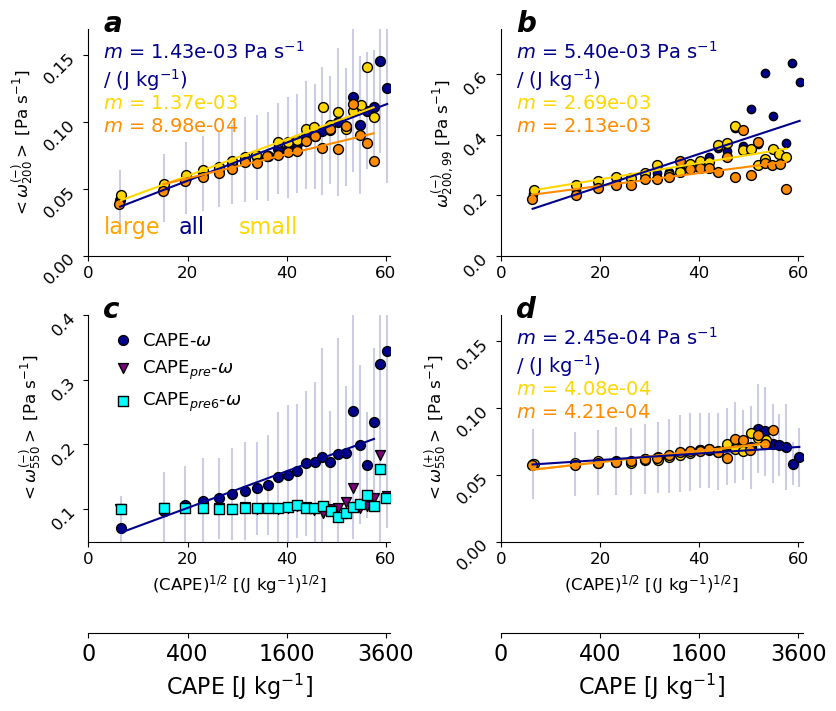

In [9]:
fig, ax = plt.subplots( 2, 2, figsize =(8.25, 7), constrained_layout=True )
sz = 50
lw = 1.5

ylab = [ r'$<\omega_{200}^{(-)}>$ [Pa s$^{-1}$]', '$\omega_{200, 99}^{(-)}$ [Pa s$^{-1}$]',
         r'$<\omega_{550}^{(-)}>$ [Pa s$^{-1}$]', r'$<\omega_{550}^{(+)}>$ [Pa s$^{-1}$]' ]
labels = [ '', '' , r'(CAPE)$^{1/2}$ [(J kg$^{-1})^{1/2}$]', '(CAPE)$^{1/2}$ [(J kg$^{-1})^{1/2}$]' ]
let = [ 'a', 'b', 'c', 'd' ]
font_size = 16
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, np.sqrt(maxcape)] )
    axis.set_xticks( [0, np.sqrt(400), np.sqrt(1600), np.sqrt(3600)] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.99, let[i], transform=axis.transAxes, fontsize=font_size+4, style='italic', weight='bold' )
    
    if i == 2:
        axis.scatter( np.sqrt(cape_bins_ascent0), ascent_vals0, s=sz, label=r'CAPE-$\omega$', color='darkblue', edgecolor='black' )
        axis.errorbar( np.sqrt(cape_bins_ascent0), ascent_vals0, yerr=ascent_error0/2, 
                      color = 'darkblue', ls='none', zorder=-1, alpha=0.2 )
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_ascent0), ascent_vals0 )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=lw, zorder=10 )
        
        axis.scatter( np.sqrt(capepre_bins_ascent), ascent_vals2, s=sz, label=r'CAPE$_{pre}$-$\omega$', color='purple', marker='v', edgecolor='black' )
        axis.scatter( np.sqrt(capepre6_bins_ascent), ascent_vals3, s=sz, label=r'CAPE$_{pre6}$-$\omega$', color='cyan', marker='s', edgecolor='black' ) 
        axis.legend( loc='upper left', frameon=False, fontsize=font_size-3, handletextpad=0.1 )
        axis.set_ylim([0.05, 0.4])
        
        ax2 = axis.secondary_xaxis( -0.4, functions=(squared, sqrt) )
        ax2.set_xticks( [0, 400, 1600, 3600] )
        ax2.set_xlabel( r'CAPE [J kg$^{-1}$]', fontsize=font_size )
        
    if i == 3:
        axis.scatter( np.sqrt(cape_bins_descent), descent_vals, s=sz, color = 'darkblue', edgecolor='black' )
        axis.errorbar( np.sqrt(cape_bins_descent), descent_vals, yerr=descent_error/2, 
                      color = 'darkblue', ls='none', zorder=-1, alpha=0.2 )
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_descent), descent_vals )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=lw, zorder=10 )
        axis.text( 0.05, 0.75, r"$m$ = " + f"{out.slope:.2e}" + r" Pa s$^{-1}$ " + "\n" + "/ (J kg$^{-1}$)", color='darkblue',
                  fontsize=font_size-2, transform=axis.transAxes )
        
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_descent_small), descent_vals_small )
        axis.scatter( np.sqrt(cape_descent_small), descent_vals_small, s=sz, color = 'gold', edgecolor='black' )
        axis.text( 0.05, 0.65, r"$m$ = " + f"{out.slope:.2e}", color='gold',
                  fontsize=font_size-2, transform=axis.transAxes )
        axis.plot( x_input, y_predicted, color='gold',  linewidth=lw )
        
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_descent_large), descent_vals_large )
        axis.scatter( np.sqrt(cape_descent_large), descent_vals_large, s=sz, color = 'darkorange', edgecolor='black' )
        axis.text( 0.05, 0.55, r"$m$ = " + f"{out.slope:.2e}", color='darkorange',
                  fontsize=font_size-2, transform=axis.transAxes )
        axis.plot( x_input, y_predicted, color='darkorange',  linewidth=lw )
        
        axis.set_ylim([0, 0.17])
        ax2 = axis.secondary_xaxis( -0.4, functions=(squared, sqrt) )
        ax2.set_xticks( [0, 400, 1600, 3600] )
        ax2.set_xlabel( r'CAPE [J kg$^{-1}$]', fontsize=font_size )
        
    if i == 0:
        axis.scatter( np.sqrt(cape_bins_ascent), ascent_vals, s=sz, color = 'darkblue', edgecolor='black' )
        axis.errorbar( np.sqrt(cape_bins_ascent), ascent_vals, yerr=ascent_error/2, 
                      color = 'darkblue', ls='none', zorder=-1, alpha=0.2 )
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_ascent), ascent_vals )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=lw )
        axis.text( 0.05, 0.75, r"$m$ = " + f"{out.slope:.2e}" + r" Pa s$^{-1}$ " + "\n" + "/ (J kg$^{-1}$)", color='darkblue',
                  fontsize=font_size-2, transform=axis.transAxes )
        print(out.slope, out.rvalue, out.pvalue)
        
        #out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_old), ascent_vals_old )
        #axis.plot( x_input, y_predicted, color='pink', linewidth=2, zorder=10 )
        
        #out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_young), ascent_vals_young )
        #axis.plot( x_input, y_predicted, color='darkred', linewidth=2, zorder=10 )
        
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_small), ascent_vals_small )
        axis.scatter( np.sqrt(cape_bins_small), ascent_vals_small, s=sz, color = 'gold', edgecolor='black' )
        axis.text( 0.05, 0.65, r"$m$ = " + f"{out.slope:.2e}", color='gold',
                  fontsize=font_size-2, transform=axis.transAxes )
        axis.plot( x_input, y_predicted, color='gold',  linewidth=lw )
        
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_large), ascent_vals_large )
        axis.scatter( np.sqrt(cape_bins_large), ascent_vals_large, s=sz, color = 'darkorange', edgecolor='black' )
        axis.text( 0.05, 0.55, r"$m$ = " + f"{out.slope:.2e}", color='darkorange',
                  fontsize=font_size-2, transform=axis.transAxes )
        axis.plot( x_input, y_predicted, color='darkorange', linewidth=lw )
        
        #out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_deep), ascent_vals_deep )
        #axis.plot( x_input, y_predicted, color='turquoise', ls='--', linewidth=2, zorder=10, alpha=0.7 )
        
        #out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_shallow), ascent_vals_shallow )
        #axis.plot( x_input, y_predicted, color='green', ls='--', linewidth=2, zorder=10, alpha=0.7 )
        axis.set_ylim([0, 0.17])
        axis.text( 0.05, 0.1, 'large', color='orange', fontsize=font_size, transform=axis.transAxes )
        axis.text( 0.3, 0.1, 'all', color='darkblue', fontsize=font_size, transform=axis.transAxes )
        axis.text( 0.5, 0.1, 'small', color='gold', fontsize=font_size, transform=axis.transAxes )
        
    if i == 1:
        axis.scatter( np.sqrt(cape_bins_ascent), ascent_99_vals, color='darkblue', edgecolor='black' )
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_ascent), ascent_99_vals )
        axis.text( 0.05, 0.75, r"$m$ = " + f"{out.slope:.2e}" + r" Pa s$^{-1}$ " + "\n" + "/ (J kg$^{-1}$)", color='darkblue',
                  fontsize=font_size-2, transform=axis.transAxes )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=lw, zorder=10 )
        
        #out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_old), ascent_99_vals_old )
        #axis.plot( x_input, y_predicted, color='pink', linewidth=2, zorder=10 )
        #print(out.slope, out.rvalue, out.pvalue)
        
        #out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_young), ascent_99_vals_young )
        #axis.plot( x_input, y_predicted, color='darkred', linewidth=2, zorder=10 )
        #print(out.slope, out.rvalue, out.pvalue)
        
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_small), ascent_99_vals_small )
        axis.scatter( np.sqrt(cape_bins_small), ascent_99_vals_small, s=sz, color = 'gold', edgecolor='black' )
        axis.text( 0.05, 0.65, r"$m$ = " + f"{out.slope:.2e}", color='gold',
                  fontsize=font_size-2, transform=axis.transAxes )
        axis.plot( x_input, y_predicted, color='gold', linewidth=lw )
        
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_large), ascent_99_vals_large )
        axis.scatter( np.sqrt(cape_bins_large), ascent_99_vals_large, s=sz, color = 'darkorange', edgecolor='black' )
        axis.text( 0.05, 0.55, r"$m$ = " + f"{out.slope:.2e}", color='darkorange',
                  fontsize=font_size-2, transform=axis.transAxes )
        axis.plot( x_input, y_predicted, color='darkorange', linewidth=lw )
        
        #out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_deep), ascent_99_vals_deep )
        #axis.plot( x_input, y_predicted, color='turquoise', ls='--', linewidth=2, zorder=10, alpha=0.7 )
        
        #out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_shallow), ascent_99_vals_shallow )
        #axis.plot( x_input, y_predicted, color='green', ls='--', linewidth=2, zorder=10, alpha=0.7 )
        axis.set_ylim([0, 0.75])

#plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/descent-CAPEpre-ERA.pdf', bbox_inches='tight' )
plt.show() 